In [3]:
# Last edited Feb 4 by GO
#  - brainstorming functions required: 
#    -- must find 'exits' from segment for each sub-segment. 
#       which requires a trace that can halt. exits defined by barriers. 
#       I think I can use this to 'crawl' the network: 
# https://doc.cgal.org/latest/BGL/group__PkgBGLSelectionFct.html#ga49398c78507f5664b740439a92ca746b

# this is a Jupyter R Notebook. 
# It can be edited and run in a browser
# the code debudgged here must be copied to the .r files
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

# Table of Contents
<a class="anchor" id="top"></a>
* [1. Imports and Intro ](#section-1)
* [2. Functions ](#section-2)
    * [2a. Function: create_basic_adjmatrix_2020 ](#section-2a)
    * [2b. Function: create_advanced_adjmatrix_2020 ](#section-2b)
    * [2c. Function: create_graph_dd_2020 ](#section-2c)
    * [2d. Function: get_paths_distances ](#section-2d)
    * [2e. Function: get_summary_tab_2020 ](#section-2e)
    * [2f. Functions: for DCI calculation ](#section-2f)
    * [2g. Function: apply_distance_limits ](#section-2g)
    * [2h. Function: apply_distance_decay](#section-2h)
* [3. Run Code With Distance Decay Option ](#section-3)
* [4. testing and benchmarking (working)](#section-4)


## 1. Imports and Intro  <a class="anchor" id="section-1"></a>
[BACK TO TOP](#top)

In [ ]:
# Code here replaces entire DCI R workflow pre-2020
# however, it requires barriers / junctions as nodes and segments as edges. 
# It uses two new output tables from FIPEX.
# FIPEX / ArcMap passes network data that includes nodes / junctions that are 
# branches in the river network (not just nodes that are barriers or sinks).
# DCIp, DCId, DCIs were all re-coded with alternatives benchmarked.
# Credit to Chris Edge (Natural Resources Canada) for DCId code that avoids loops in R.
# Please see accompanying Powerpoint for workflow diagrams. 
# - G Oldford, 2020

In [1]:
# libraries
library(RBGL) #required, part of bioconductr
library(Rgraphviz)
library(rbenchmark)
library(data.table) #required
library(tidyverse) #required

# Jupyter R Notebooks can install packages:
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")
#BiocManager::install("RBGL")

# new in 2020:
# (others may be used in experiemnts below but these are required as of 2020)
#install.packages("rbenchmark", repos='http://cran.us.r-project.org')
#install.packages("data.table", repos='http://cran.us.r-project.org')
#install.packages("tidyverse", repos='http://cran.us.r-project.org')

# Note 2020: 
# Some original files were modified to upgrade to newer version of R (3.6.1)
# variable names and functions with . were replaced with _ to avoid confusion 
# the visualization function 

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: grid
Warning message:
"package 'data.table' was built un

In [2]:
# 'Advanced' table includes network edges and nodes
# with all original branch junctions in the GIS data 
# kept, even if they aren't barriers
# The 'advanced' table includes all info required to run DCI
# (previously two tables were required from FIPEX)
FIPEX_table=read.csv("FIPEX_Advanced_DD_2020.csv")

# ensure it's "sink" not "Sink"
FIPEX_table <- FIPEX_table %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",as.character(DownstreamEID)))
FIPEX_table

NodeType,NodeEID,NodeLabel,HabQuantity,HabUnits,BarrierPerm,NaturalTF,DownstreamEID,DownstreamNodeLabel,DownstreamNeighDistance,DistanceUnits
<fct>,<int>,<int>,<dbl>,<fct>,<dbl>,<lgl>,<chr>,<fct>,<dbl>,<fct>
Branch Junction,12,189,363.90,Metres,1.00,FALSE,sink,Sink,363.90,Metres
Barrier,14,300101,440.20,Metres,0.98,FALSE,12,189,440.20,Metres
Branch Junction,15,177,771.07,Metres,1.00,FALSE,12,189,771.07,Metres
Barrier,23,300009,1484.06,Metres,0.99,FALSE,14,300101,1484.06,Metres
Source Junction,17,182,570.44,Metres,1.00,FALSE,15,177,570.44,Metres
Barrier,18,300055,1062.16,Metres,0.99,FALSE,15,177,1062.16,Metres
Barrier,24,300056,258.35,Metres,0.97,FALSE,23,300009,258.35,Metres
Barrier,19,300036,18.74,Metres,0.98,FALSE,18,300055,18.74,Metres
Barrier,25,300090,16.91,Metres,0.99,FALSE,24,300056,16.91,Metres


In [3]:
# The params file allows users to pass param settings
# to R from within the ArcMap software (new in 2020)
FIPEX_params=read.csv("FIPEX_2020_params.csv")
FIPEX_params

bDCISectional <- as.logical(FIPEX_params$bDCISectional)
bDistanceLim <- as.logical(FIPEX_params$bDistanceLim)
dMaxDist <- as.double(FIPEX_params$dMaxDist)
bDistanceDecay <- as.logical(FIPEX_params$bDistanceDecay)
sDDFunction <- as.character(FIPEX_params$sDDFunction)

bDCISectional,bDistanceLim,dMaxDist,bDistanceDecay,sDDFunction
<fct>,<fct>,<int>,<fct>,<fct>
True,True,450,True,natexp1


# 2. Functions <a class="anchor" id="section-2"></a>
[BACK TO TOP](#top)

## 2 a) function: create_basic_adjmatrix_2020
<a class="anchor" id="section-2a"></a>
[BACK TO TOP](#top)

In [4]:
###### CREATE BASIC ADJACENCY MATRIX #####
# no edge weights, useful for DCI with no distance decay
# rbgl requires adjacency matrix 
# FIPEX outputs adjacency table so need to convert
# note: igraph requires only adjacency table

# library(rbenchmark) can be used to test
#https://stackoverflow.com/questions/34355892/build-a-square-adjacency-matrix-from-data-frame-or-data-tablelevs <- unique(unlist(neighbournodes_all, use.names=F))

create_basic_adjmatrix_2020 <- function(neighbournodes_all,option="2020_tapply") {
    # binary adjacency matrix defining connectivity
    
    if(option=="2020_tapply"){
        neighbournodes_all$edgeLength <- 1
        adj_matrix <- with(neighbournodes_all, tapply(edgeLength, list(Node1, Node2),FUN=length, default = 0))
        
    }else if(option=="2020_dfmatrix"){
        matrix_table <- table(neighbournodes_all)
        adj_mat1 <- as.data.frame.matrix(matrix_table)
        adj_matrix <- as.matrix(adj_mat1)
        
    }else if(option=="oldway"){
        
        # pre-2020 code
        segments<-with(neighbournodes_all, unique(Node2))
        #create a matrix with only 0's in them
        adj_matrix<-matrix(nrow=length(segments), 
                       ncol=length(segments), 
                       rep(0,length(segments)*length(segments)))
        segment_length<-length(segments)
        rownames(adj_matrix)<-colnames(adj_matrix)<-segments

        for (i in 1:segment_length){
            # find the segments in segment.matrix$Seg where segment.matrix$Seg_ID matches segments[i]
            # index of matching positions - this will be a vector of 1's and NA's
            pos_match<-	match(neighbournodes_all$Node2,segments[i])
        
            # keep only the positions where pos.match==1
            adj_segments<-neighbournodes_all$Node1[!is.na(pos_match)]

            # find the column positions that correspond to the adjacaent segments
            col<-match(adj_segments,segments)

            # the row number should correspond to i
            row<-i

            # assign a value of 1 for all values of row and col
            adj_matrix[row,col]<-1
        }
    }  
    adj_matrix
}

# check (need neighbournodes_all to check)
# dimensions should match
#dim(create_adjmatrix_2020(neighbournodes_all,"2020_tapply"))
#dim(create_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"))
#dim(create_adjmatrix_2020(neighbournodes_all,"oldway"))

In [5]:
# examples / cross-checks
totalhabitat = sum(FIPEX_table$HabQuantity)
totallength = sum(FIPEX_table$DownstreamNeighDistance)
print("For cross checks in GIS:")
print(totalhabitat)
print(totallength)

[1] "For cross checks in GIS:"
[1] 150664.1
[1] 150664.1


## 2 b) function: create_advanced_adjmatrix_2020
<a class="anchor" id="section-2b"></a>
[BACK TO TOP](#top)

In [6]:
################################################################
# edge-weighted connectivity list (edges_all) and matrix - for DCI w/ DD
# nodes / edges are not reversed as in original way
# do not need self-connected

create_advanced_adjmatrix_2020 <- function(FIPEX_table=NULL){

    # get connectivity list, convert columns to characters
    FIPEX_table_DD <- FIPEX_table %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
    mutate(temp = as.character(NodeEID)) %>%
    mutate(NodeEID = temp) %>%
    mutate(temp = as.character(DownstreamEID)) %>%
    mutate(DownstreamEID = temp) %>%
    select(-temp) %>%
    mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",DownstreamEID))

    # downstream neighbours
    edges_down <- FIPEX_table_DD

    # upstream neigbours
    edges_up <- FIPEX_table_DD %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
    mutate(temp = DownstreamEID) %>%
    mutate(DownstreamEID = NodeEID) %>%
    mutate(NodeEID = temp) %>%
    select(-temp)

    # self-connected
    #FIPEX_table %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
    #mutate(NodeEID = DownstreamEID, DownstreamNeighDistance = 0.1)

    # merge
    edges_all <- edges_down %>%
    bind_rows(edges_up) %>%
    #add_row(NodeEID = "sink", DownstreamEID = "sink") %>%
    rename(Node1 = NodeEID, Node2 = DownstreamEID, edgeLength = DownstreamNeighDistance)
    
    # convert to matrix
    adj_matrix_edgelengths <- with(edges_all, tapply(edgeLength, list(Node1, Node2), FUN=sum, default = 0))
    
    return(adj_matrix_edgelengths)
}

In [7]:
# examples / cross checks
adj_matrix_edgelengths <- create_advanced_adjmatrix_2020(FIPEX_table)
adj_matrix_edgelengths

,1,100,101,103,104,105,107,108,109,110,...,9,90,92,93,94,96,97,98,99,sink
1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
100,0,0.00,365.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,10.96,0.0
101,0,365.59,0.00,718.75,0.00,0.00,1079.48,0.00,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
103,0,0.00,718.75,0.00,0.00,0.00,0.00,0.00,0.00,549.47,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
104,0,0.00,0.00,0.00,0.00,178.44,0.00,0.00,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
105,0,0.00,0.00,0.00,178.44,0.00,188.36,0.00,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
107,0,0.00,1079.48,0.00,0.00,188.36,0.00,377.54,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
108,0,0.00,0.00,0.00,0.00,0.00,377.54,0.00,71.49,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
109,0,0.00,0.00,0.00,0.00,0.00,0.00,71.49,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0
110,0,0.00,0.00,549.47,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0.00,0,0,0.00,0.00,0,0.00,0.0


## 2 c) Function: create_graph_dd_2020
<a class="anchor" id="section-2c"></a>
[BACK TO TOP](#top)

In [ ]:
#to do: alternative graph creation using igraph
# benchmark
# note most code below assumes using an RGBL Boost GraphAM object,
#  so to test alternative it would require a lot of alternative code,
#  potentially

In [8]:
################################################################
# CREATE GRAPH OBJECT for DCI w/ Distance Decay
# edge weights are used for distance calculations
# edge data / attributes used for habitat quantity calculations
# #https://www.rdocumentation.org/packages/graph/versions/1.50.0/topics/graphAM-class
create_graph_dd_2020 <- function(adj_matrix_edgelengths=0.0,FIPEX_table=NULL){

    # Create graph object
    # 2020 - different way to call the graphAM function 
    # vs pre-2020
    # - this is hard to track down but the graphAM (adjacency matrix) is from the 'graph'
    #   package
    g_dd <- graphAM(adjMat=adj_matrix_edgelengths,  edgemode="directed", values=list(weight=1))

    # associate passabilities with nodes using NodeData slot
    # e.g. nodeData(g,n=c("b", "c"), attr ="color") <- "red"
    nodeDataDefaults(g_dd, attr ="pass") <- 1.0
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="pass") <- as.double(FIPEX_table$BarrierPerm)
    #nd <- nodes(g_dd)

    nodeDataDefaults(g_dd, attr ="nodelabel") <- "none"
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="nodelabel") <- as.character(FIPEX_table$NodeLabel)
    nodeData(g_dd,n="sink", attr="nodelabel") <- "sink"
    #nd <- nodes(g_dd)

    nodeDataDefaults(g_dd, attr ="downnodelabel") <- "none"
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="downnodelabel") <- as.character(FIPEX_table$DownstreamNodeLabel)
    #nd <- nodes(g_dd)

    nodeDataDefaults(g_dd, attr ="natural") <- "none"
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="natural") <- FIPEX_table$NaturalTF
    nodeData(g_dd,n="sink", attr="natural") <- FALSE
    #nd <- nodes(g_dd)

    # optionally can give edges attributes
    #edgeDataDefaults(g_dd, attr="name")<-"noname"
    #edgeData(self, from, to, attr)
    #edgeData(self, from, to, attr) <- value
    edgeDataDefaults(g_dd, attr="HabitatQuan")<-0.0
    edgeData(g_dd,from=as.character(FIPEX_table$NodeEID), 
         to=as.character(FIPEX_table$DownstreamEID), 
         attr="HabitatQuan")<-as.double(FIPEX_table$HabQuantity)
    # reverse - attr associated with each direction along one edge
    edgeData(g_dd,from=as.character(FIPEX_table$DownstreamEID), 
         to=as.character(FIPEX_table$NodeEID), 
         attr="HabitatQuan")<-as.double(FIPEX_table$HabQuantity)


    # give edges an easy-to-access name insensitive to direction
    # this is done to quickly identify duplicates later
    # there may be alternatives such as accessing edgeNames but I suspect
    # they are slower than this
    edgeDataDefaults(g_dd, attr="EdgeNameGO")<-"init"
    edgeData(g_dd,from=as.character(FIPEX_table$NodeEID), 
         to=as.character(FIPEX_table$DownstreamEID), 
         attr="EdgeNameGO")<-paste(as.character(FIPEX_table$DownstreamEID),
                                   as.character(FIPEX_table$NodeEID),
                                   sep="-")
    # reverse - attr associated with each direction along one edge
    edgeData(g_dd,from=as.character(FIPEX_table$DownstreamEID), 
         to=as.character(FIPEX_table$NodeEID), 
         attr="EdgeNameGO")<-paste(as.character(FIPEX_table$DownstreamEID),
                                   as.character(FIPEX_table$NodeEID),
                                   sep="-")
    return(g_dd)
}

In [9]:
# example
g_dd<-create_graph_dd_2020(adj_matrix_edgelengths,FIPEX_table)

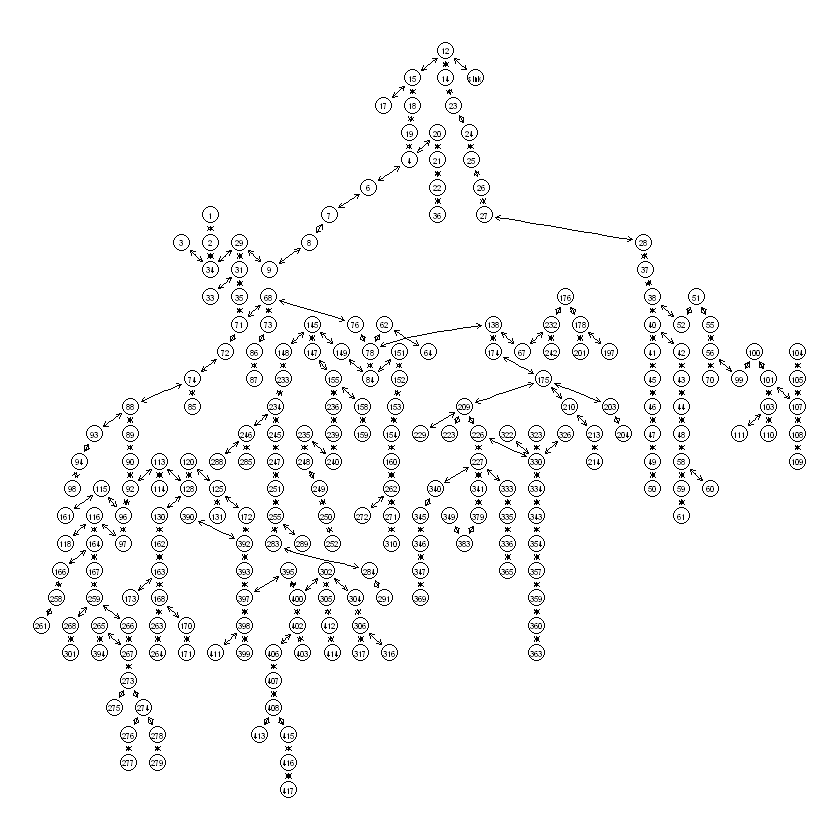

In [10]:
# Test visual with defaults

# note ignore the bidirectional arrows
# to do: add refined visuals function
library(Rgraphviz)

plot(g_dd)

## Function: get_paths_distances
<a class="anchor" id="section-2d"></a>
[BACK TO TOP](#top)

In [11]:
################################################################################
# get all distances and paths (from penult) to all nodes from Sink / all nodes
# https://www.rdocumentation.org/packages/RBGL/versions/1.48.1/topics/dijkstra.sp
# note it must be node-node - no edge-edge possible
# note using this function repeatedly during DCIp is inefficient 
# !!! (should use BFS w/ Least Common Ancestors (LCA) i.e., custom algorithm) !!!
#   (cannot edit the source for Djikstra.sp because it's actually an 
#   interface to C++ 'Boost'library for graphs - can't get edge and node attributes 
#   during net traversal)

# change this so node i, j combos not i to every j each time... 

get_paths_distances <- function(g=NULL,fromnode="sink"){
    dijkstra.sp(g,fromnode,eW=unlist(edgeWeights(g)))
    
    # TO DO: ALTERNATIVES FOR BENCHMARKING
}

In [12]:
# Example 
paths_distances_sink <- get_paths_distances(g_dd,"sink")
# returns distance from sink to x
paths_distances_sink$distances["48"]
paths_distances_sink


48 
4022.29

$distances
       1      100      101      103      104      105      107      108 
 7128.26  6411.92  6777.51  7496.26  8223.79  8045.35  7856.99  8234.53 
     109      110      111      113      114      115      116      118 
 8306.02  8045.73  7853.06  9914.67 10252.52 10479.66 10423.96 10744.35 
      12      120      125      128      130      131      138       14 
  363.90 11913.25 12577.11 11441.01 11717.26 12985.81 11942.51   804.10 
     145      147      148      149       15      151      152      153 
13264.41 13448.62 13424.02 12527.90  1134.97 12544.47 13071.44 13083.41 
     154      155      158      159      160      161      162      163 
13235.88 13572.95 14027.79 14039.65 13384.09 11618.23 13024.41 13557.64 
     164      166      167      168       17      170      171      172 
12767.36 12921.13 13859.06 14553.67  1705.41 15371.66 15387.78 14212.90 
     173      174      175      176      178       18       19      197 
13938.96 15330.37 15353.29 15488.13 15851.36  2197.13  2215.87 16331.59 
       2       20      201      203      204      209       21      210 
 6573.08  3378.00 16624.63 18118.69 18128.97 17839.33  3618.50 17950.43 
     213      214       22      223      226      227      229       23 
17962.23 18115.56  3624.99 18954.44 19359.74 19608.37 18292.84  2288.16 
     232      233      234      235      236      239       24      240 
14591.52 13888.85 14394.71 15167.13 14191.46 14762.75  2546.51 14881.12 
     242      245      246      247      248      249       25      250 
15943.97 15318.83 15358.22 15576.04 15481.93 15498.20  2563.42 15742.21 
     251      252      255      258      259       26      261      262 
15755.08 15980.41 16097.46 13711.04 14520.85  2577.17 13990.26 15231.99 
     263      264      265      266      267      268       27      271 
15478.23 15590.00 16129.98 15087.41 15359.72 15727.93  2745.47 17379.39 
     272      273      274      275      276      277      278      279 
17513.86 16065.49 16159.90 16369.89 16312.10 16312.80 16572.27 16712.86 
      28      283      284      285      288      289       29      291 
 3001.49 17757.31 17769.97 17785.09 18095.44 18344.00  5092.89 18730.77 
       3      301      302      304      305      306       31      310 
 6604.67 16932.97 20457.58 20593.68 20772.69 20891.84  5215.14 18813.89 
     316      317      322      323      326       33      330      333 
21556.67 21719.90 21248.56 21964.99 20811.28  5240.04 20332.47 20269.34 
     334      335      336       34      340      341      343      345 
20511.77 20633.39 20672.39  6310.66 21296.95 21233.92 21319.90 21822.35 
     346      347      349       35      354      357      359       36 
21890.32 22608.79 23176.78  5751.08 23259.36 25215.81 25266.09  3828.78 
     360      363      365      369       37      379       38      383 
25409.36 26737.32 23613.00 24099.05  3384.23 22141.33  3534.16 22316.33 
     390      392      393      394      395      397      398      399 
17607.26 17105.46 17803.89 17305.41 19056.88 18704.60 19269.98 19432.11 
       4       40      400      402      403      406      407      408 
 2714.19  3613.37 19957.97 20092.05 20254.64 20260.25 20263.37 20329.22 
      41      411      412      413      414      415      416      417 
 3663.45 19644.51 20874.20 20665.54 21421.25 20959.86 21244.68 21609.42 
      42       43       44       45       46       47       48       49 
 3710.62  3714.92  3860.07  3836.38  3903.00  4044.13  4022.29  4213.88 
      50       51       52       55       56       58       59        6 
 4693.43  4794.50  4783.55  5859.12  5903.68  4696.46  4830.14  3279.69 
      60       61       62       64       67       68        7       70 
 5105.00  5570.63 11510.59 12256.58 14049.52  8392.61  3653.08  6805.23 
      71       72       73       74       76       78        8       84 
 8074.43  8409.72  8715.72  8620.18  8975.69  9255.15  3714.65 10676.58 
      85       86       87       88       89   

## 2 e) Function: get_summary_tab_2020
<a class="anchor" id="section-2e"></a>
[BACK TO TOP](#top)

In [13]:
##############################################################################
##### SUMMARY TABLE 2020 #####

# replaces similar pre-2020 function to create a table containing each edge-edge pair
# Includes options for alternative data management for benchmarking
# (code could be trimmed).
# this function could be sped up with custom algorithm that can find path 
# while also grabbing attribute data (BFS w/ LCA). 
# - G Oldford, 2020

# gets cumulative passability each pair using path info
# and get other attributes

# pseudocode:
# for each 'from node' (e.g., sink in DCId, and all nodes in DCIp)
#  get paths between node and all other node
#
#  for each 'to node' in 'all paths' results
#   get the first edge len and hab traversed from node to sink
#
#   store length and hab of the edge between 'to node' and first node encountered
#   in path back to 'from node' (i.e., the 'to edge')

#   do while next node name <> "from node"
#     pass = nodeData(g_dd, nextnode, "pass")
#     cumulativepass =  cumulativepass * pass
#     nextnode = the next node in path towards 'from node'
#     if last edge traversed on the way to 'from node'
#       store the length and habitat of this edge which is the 'from edge'
#     if there is a maxdistance set for distance decay, 
#       add a TRUE/FALSE column to indicate this
#   
#   
#   add various other attributes to master table (attr's from g object)

# requires library(data.table)
# data.table vs other options likely to speed things up for large networks
#https://rstudio-pubs-static.s3.amazonaws.com/406521_7fc7b6c1dc374e9b8860e15a699d8bb0.html
#https://www.rdocumentation.org/packages/data.table/versions/1.13.0/topics/rbindlist

get_summary_tab_2020 <- function(option="dt-lists",
                                 naturalonly=FALSE,
                                 g = NULL,
                                 DCIp=FALSE,
                                 bDistanceLim=FALSE,
                                 dMaxDist=0.0){
    
    # funciton params:
    # option - for benchmarking speed of appending to table
    # naturalonly - will calculate pass-weighted path distances
    #  while ignoring non-natural barriers
    # g - the graph object (rbgl GraphAM in BioconductR)
    # DCIp - TRUE / FALSE will trigger loop that finds path
    #       between all nodes, node just sink
    # initialize empty data object in different ways
    
    # for different options and benchmarking:
    DT2 = data.table(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 DistMinusSEExceedsThreshold=FALSE,
                 FromEdgeHab=0.0,
                 ToEdgeHab=0.0,
                 ToEdgeName="init",
                 FromEdgeName="init",
                 ToFromEdgeNameCombo="init")
    
    DF2 = data.frame(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 DistMinusSEExceedsThreshold=FALSE,
                 FromEdgeHab=0.0,
                 ToEdgeHab=0.0,
                 ToEdgeName="init",
                 FromEdgeName="init",
                 ToFromEdgeNameCombo="init", stringsAsFactors=F)
    
    # lists in R must have size pre-allocated 
    # size of our table is almost n^2 - n*(n-1) 
    # (less than n^2 since not getting distance from node to itself)
    if(DCIp==FALSE){
        outlist <- vector("list", length(numNodes(g_dd)))
    }else{
        outlist <- vector("list", length(numNodes(g_dd)*(numNodes(g_dd)-1)))   
    }
    
    outlist[[numNodes(g_dd)]] <- list(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 DistMinusSEExceedsThreshold=FALSE,
                 FromEdgeHab=0.0,
                 ToEdgeHab=0.0,
                 FromEdgeName="init",
                 ToEdgeName="init",
                 ToFromEdgeNameCombo="init")

    # from = sink / start node
    # to = other nodes
    if(DCIp==FALSE){
        fromnodecount=1
    }else{
        fromnodecount=numNodes(g_dd)
    }
    
    bDistMinusSEExceedsThreshold = FALSE
    count = 0
    for (j in 1:fromnodecount){
   
        if(DCIp==FALSE){
            fromnode_name = "sink"
            fromnode_label = "sink" 
        }else{
            fromnode_name = nodes(g_dd)[j]
             if (fromnode_name=="sink"){
                fromnode_label = "sink"
            }else{
                fromnode_label = nodeData(g_dd, fromnode_name, "nodelabel")[[1]]  
            }
        }
        
        ###########################################################
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # get path & distances between 'fromnode' and all other nodes
        paths_distances <- get_paths_distances(g,fromnode_name)
        # this can be time consuming
        
    for (k in 1:length(paths_distances$penult)) {
        
        tonode <- paths_distances$penult[k]     
        tonode_name = names(tonode)
        tonode_name <- tonode_name[[1]]
        tonode_label = nodeData(g_dd, tonode_name, "nodelabel")[[1]]
    
        if (tonode_name == fromnode_name){
            # not interested in distance from one node to itself
            next
        }
        count = count+1
        # initialize
        cumulativepass = 1.0
        pass = 1.0 # watch not to take pass from to/from end nodes since traversal starts at edge
        totaldistance = paths_distances$distances[tonode_name]
        totaldistance <- totaldistance[[1]]     
        
        # get length of edge 
        nextnode = paths_distances$penult[tonode]
        nextnode_name = names(nextnode)
        lastnode_name = tonode_name
    
        # get the last edge length traversed on the way to 'to node'
        # alternatively could grab the weight for this edge instead of subtraction
        toedgelen = totaldistance - paths_distances$distances[nextnode_name]
        toedgelen <- toedgelen[[1]]
        toedgedata =edgeData(g_dd, tonode_name,nextnode_name)
        toedgehab = toedgedata[[1]]$HabitatQuan
        toedgename = toedgedata[[1]]$EdgeNameGO
        
        exitvar = "go"
        while (exitvar != "stop"){
        
            if(nextnode_name != fromnode_name){
                pass = nodeData(g_dd, nextnode_name, "pass")
                if(naturalonly==FALSE){
                    cumulativepass = cumulativepass * pass[[1]]
                }else{
                    natural = nodeData(g_dd,nextnode_name,"natural")
                    if(natural[[1]]==TRUE){
                        cumulativepass = cumulativepass * pass[[1]]
                    }
                }
            }else{
                fromedgelen = paths_distances$distances[lastnode_name]
                fromedgelen <- fromedgelen[[1]]
                fromedgedata = edgeData(g_dd, lastnode_name,fromnode_name)
                fromedgehab = fromedgedata[[1]]$HabitatQuan
                fromedgename = fromedgedata[[1]]$EdgeNameGO
                
                exitvar="stop"
            }
            
            lastnode_name = nextnode_name
            nextnode = paths_distances$penult[nextnode]
            nextnode_name = names(nextnode)
        }
        
       distminusstartendlen = totaldistance - toedgelen - fromedgelen
       # less than zero distance indicates it's an edge-to-itself distance
       # correct for this
       if (distminusstartendlen<0){
          distminusstartendlen = 0 
       }
        
       tofromedgename_combo = paste(toedgename,fromedgename,sep="|")
       
       if (bDistanceLim == TRUE){
           if (distminusstartendlen > dMaxDist){
               bDistMinusSEExceedsThreshold=TRUE
           }else{
               bDistMinusSEExceedsThreshold=FALSE
           }
       }else{
           bDistMinusSEExceedsThreshold=FALSE
       }
       
        if (option=="dt"){
            #print(cumulativepass)
            #https://www.rdocumentation.org/packages/data.table/versions/1.13.0/topics/rbindlist
            DT1 = data.table(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHabLen=fromedgehablen,
                     ToEdgeHab=toedgehab,
                     FromEdgeHab=fromedgehab,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            l = list(DT1,DT2)
            
            DT2 = rbindlist(l, use.names=TRUE)
        }else if(option=="dt-lists"){
            # append lists to list rather than work yet with tables
            DL1 = list(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=fromedgehab,
                     ToEdgeHab=toedgehab,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print("Length DL1: ")
            #print(length(DL1))
            outlist[[count]] <- (DL1)
            
        }else if(option=="df"){
            DF1 = data.frame(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=fromedgehab,
                     ToEdgeHab=toedgehab,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print(fromedgehabarea)
            #print(DF1)
            DF2 <- rbind(DF2, DF1)
          }else if(option=="df-lists"){
            DL1 = list(FromNode=as.character(fromnode_name),
                     ToNode=as.character(tonode_name),
                     FromNodeLabel=as.character(fromnode_label),
                     ToNodeLabel=as.character(tonode_label),
                     CumulativePass=as.numeric(cumulativepass), 
                     FromEdgeLen=as.numeric(fromedgelen),
                     ToEdgeLen=as.numeric(toedgelen),
                     TotalDist=as.numeric(totaldistance),
                     DistMinusStartEndLen=as.numeric(distminusstartendlen),
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=fromedgehab,
                     ToEdgeHab=toedgehab,
                     FromEdgeName=as.character(fromedgename),
                     ToEdgeName=as.character(toedgename),
                     ToFromEdgeNameCombo=as.character(tofromedgename_combo))
            outlist[[count]] <- (DL1)
        }else if(option=="dplyr"){
             DL1 = list(FromNode=as.character(fromnode_name),
                     ToNode=as.character(tonode_name),
                     FromNodeLabel=as.character(fromnode_label),
                     ToNodeLabel=as.character(tonode_label),
                     CumulativePass=as.numeric(cumulativepass), 
                     FromEdgeLen=as.numeric(fromedgelen),
                     ToEdgeLen=as.numeric(toedgelen),
                     TotalDist=as.numeric(totaldistance),
                     DistMinusStartEndLen=as.numeric(distminusstartendlen),
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=as.numeric(fromedgehab),
                     ToEdgeHab=as.numeric(toedgehab),
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print(row1)
            DF2 <- bind_rows(DF2,DL1)
        }
    } #k
    } #j
        
    if(option=="dt"){
        sum_tab <- DT2
    }else if(option=="dt-lists"){
        DT2 <- data.table(rbindlist(outlist))
        
        sum_tab <- DT2
    }else if(option=="df"){
        #DF2 <- DF2[!duplicated(DF2$ToFromEdgeNameCombo), ]
        sum_tab <- DF2
    }else if(option=="df-lists"){
        DF2 <- data.frame(do.call(rbind, outlist))
        #DF2 <- DF2[!duplicated(DF2$ToFromEdgeNameCombo), ]
        sum_tab <- DF2
    }else if(option=="dplyr"){
        sum_tab <- DF2
    }
        
    # if a distance limit, eliminate rows
    if(bDistanceLim == TRUE){
        return(sum_tab[DistMinusSEExceedsThreshold==FALSE])
    }else{
        return(sum_tab) 
    } 
          
}


In [14]:
# example usage
# warning 'df-lists' does not work - it creates list type columns
#    which will cause errors in DCI calc!
sum_tab_2020 <- get_summary_tab_2020(option="dt-lists",
                                     naturalonly=FALSE,
                                     g = g_dd,
                                     DCIp=TRUE,
                                     bDistanceLim=TRUE,
                                     dMaxDist=1000
                                    )
sum_tab_2020 

FromNode,ToNode,FromNodeLabel,ToNodeLabel,CumulativePass,FromEdgeLen,ToEdgeLen,TotalDist,DistMinusStartEndLen,DistMinusSEExceedsThreshold,FromEdgeHab,ToEdgeHab,FromEdgeName,ToEdgeName,ToFromEdgeNameCombo
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,2,78,300106,1.0000,555.18,555.18,555.18,0.00,FALSE,555.18,555.18,2-1,2-1,2-1|2-1
1,29,78,123,0.9800,555.18,1217.77,2035.37,262.42,FALSE,555.18,1217.77,2-1,29-34,29-34|2-1
1,3,78,77,0.9800,555.18,294.01,1111.61,262.42,FALSE,555.18,294.01,2-1,34-3,34-3|2-1
1,34,78,85,0.9800,555.18,262.42,817.60,0.00,FALSE,555.18,262.42,2-1,34-2,34-2|2-1
100,101,300093,186,1.0000,365.59,365.59,365.59,0.00,FALSE,365.59,365.59,100-101,100-101,100-101|100-101
100,103,300093,191,1.0000,365.59,718.75,1084.34,0.00,FALSE,365.59,718.75,100-101,101-103,101-103|100-101
100,107,300093,212,1.0000,365.59,1079.48,1445.07,0.00,FALSE,365.59,1079.48,100-101,101-107,101-107|100-101
100,110,300093,204,1.0000,365.59,549.47,1633.81,718.75,FALSE,365.59,549.47,100-101,103-110,103-110|100-101
100,111,300093,183,1.0000,365.59,356.80,1441.14,718.75,FALSE,365.59,356.80,100-101,103-111,103-111|100-101


In [15]:
class(sum_tab_2020) # just a note data tables are both df and dt

[1] "data.table" "data.frame"

In [35]:
### benchmarking different approaches to summary table creation
# test with a large (1000's nodes) dataset 
library(rbenchmark)

benchmark(get_summary_tab_2020(option="dt",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="dt-lists",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="df",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="df-lists",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="dplyr",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          replications=40)
#dt-lists fastest

,test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,"get_summary_tab_2020(option = ""df-lists"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,1.91,1.000,1.91,0.00,NA,NA
3,"get_summary_tab_2020(option = ""df"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,10.44,5.466,10.39,0.00,NA,NA
5,"get_summary_tab_2020(option = ""dplyr"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,2.25,1.178,2.25,0.00,NA,NA
2,"get_summary_tab_2020(option = ""dt-lists"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,1.92,1.005,1.91,0.02,NA,NA
1,"get_summary_tab_2020(option = ""dt"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,4.70,2.461,4.60,0.04,NA,NA


## 2 f) Functions for DCI calculation
<a class="anchor" id="section-2f"></a>
[BACK TO TOP](#top)

In [16]:
########################################################
###### Calculate DCI #####
#dci_calc_2020_dd <- function(){}
# warning: the sum_tab_2020 must be a data.table
#          only some data frames work ('dplyr' is ok not
#          the 'df-lists' option)


######### (1) DCId - calc_DCId #########
calc_DCId_2020 <- function(sum_tab_2020=NULL,
                           totalhabitat=0.0,
                           FromNode="sink",
                           bDistanceLim=FALSE){
    
    # filter table
    DCId_data<-subset(sum_tab_2020,FromNode=="sink")
    
    # Credit to Chris Edge Code for avoiding loops in R here: 
    if(bDistanceLim==FALSE){
        DCId_data$temp <- DCId_data$CumulativePass * (DCId_data$ToEdgeHab/totalhabitat)
    }else{
        DCId_data$temp <- DCId_data$CumulativePass * (DCId_data$ToEdgeHabMaxAccessible/DCId_data$MaxTotalAccessHabFromEdge)
    }
    DCId <- sum(DCId_data$temp)
    return(round(DCId*100,2))
} # DCId

######### (2) DCIp - calc_DCIp #########
# Credit to C Edge for shorter code
calc_DCIp_2020 <- function(sum_tab_2020=NULL,
                           totalhabitat=0.0,
                           option="unique",
                           bDistanceLim=FALSE){
    
    # 'option' = unique / distinct for benchmarking speeds
    # unique = data.table / base r
    # distinct = dplyr
    # to do: sometimes sum_tab may be a data.table sometimes data.frame
    if(option=="unique"){
        sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    }else{
        sum_tab_2020 <- distinct(sum_tab_2020, ToFromEdgeNameCombo, .keep_all = TRUE)
    }

    DCIp <- 0
    if(bDistanceLim==FALSE){
        for (i in 1:nrow(sum_tab_2020)) {
            DCIp <- DCIp + (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$FromEdgeHab[i]/totalhabitat)) * (sum_tab_2020$ToEdgeHab[i]/totalhabitat)
        }
    }else{
        for (i in 1:nrow(sum_tab_2020)) {
            DCIp <- DCIp + (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$FromEdgeHab[i]/totalhabitat))* (sum_tab_2020$ToEdgeHabMaxAccessible[i]/sum_tab_2020$MaxTotalAccessHabFromEdge[i]) 
        }
    }
    return(round(DCIp*100,2))
}

######### (3) DCIs - calc_DCIs #########
# can be added into (2) as option see below
calc_DCIs_2020 <- function (sum_tab_2020=NULL,
                            totalhabitat=0.0,
                            option="dt",
                            bDistanceLim=FALSE){
    
    # option: "dt","dplyr","old"
    # alternative methods for benchmarking
    if(option=="dt"){
        
        DCIs <- sum_tab_2020
        # remove duplicates
        DCIs <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
        
        if(bDistanceLim==FALSE){
            # select only a required columns
            cols = c("FromEdgeName","ToEdgeHab","CumulativePass")
            DCIs <- DCIs[,..cols]
            # first step to DCIs
            DCIs[, DCIs_i := round(ToEdgeHab/totalhabitat * CumulativePass * 100,2)]
        }else{
            # select only a required columns
            cols = c("FromEdgeName","ToEdgeHabMaxAccessible","CumulativePass","MaxTotalAccessHabFromEdge")
            DCIs <- DCIs[,..cols]
            # first step to DCIs
            DCIs[, DCIs_i := round(ToEdgeHabMaxAccessible/MaxTotalAccessHabFromEdge * CumulativePass * 100,2)]
        }
        
        cols = c("FromEdgeName","DCIs_i")
        DCIs <- DCIs[,..cols]
        # second step to DCIs
        DCIs <- DCIs[, lapply(.SD,sum), by=.(FromEdgeName)]
        
    }else if(option=="dplyr"){
        
        if(bDistanceLim==FALSE){
            DCIs <- sum_tab_2020 %>%
            distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
            mutate(DCIs_i = CumulativePass * ToEdgeHab/totalhabitat * 100) %>%
            select(DCIs_i,FromEdgeName) %>%
            group_by(FromEdgeName) %>%
            summarise(DCIs = sum(DCIs_i))
        }else{
            DCIs <- sum_tab_2020 %>%
            distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
            mutate(DCIs_i = CumulativePass * ToEdgeHabMaxAccessible/MaxTotalAccessHabFromEdge)*100 %>%
            select(DCIs_i,FromEdgeName) %>%
            group_by(FromEdgeName) %>%
            summarise(DCIs = sum(DCIs_i))
        }
        
        
    }else if(option=="old"){
        sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
        sections<-as.vector(unique(sum_tab_2020$FromEdgeName))
        # store the all section results in DCI.as
        DCI_as<-NULL
        
        for(s in 1:length(sections)){
            DCI_s<-0
            # Old notes:
            # select out only the data that corresponds to pathways from one sectino 
            # to all other sections
            d_nrows<-subset(sum_tab_2020, FromEdgeName==sections[s])
            d_sum_table<-d_nrows
            
            if(bDistanceLim==FALSE){
                for (a in 1:dim(d_nrows)[1]){
                    # Old note:
                    #to get the DCI for diadromous fish, use the following formula: 
                    # DCId= li/L*Cj (where j= the product of the passability in the pathway)
                    la<-d_sum_table$ToEdgeHab[a]/sum(FIPEX_table$HabQuantity)
                    pass_d<-d_sum_table$CumulativePass[a]
                    DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
                } # end loop over sections for dci calc
            }else{
                for (a in 1:dim(d_nrows)[1]){
                    # Old note:
                    #to get the DCI for diadromous fish, use the following formula: 
                    # DCId= li/L*Cj (where j= the product of the passability in the pathway)
                    la<-d_sum_table$ToEdgeHabMaxAccessible[a]/d_sum_table$MaxTotalAccessHabFromEdge
                    pass_d<-d_sum_table$CumulativePass[a]
                    DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
                } # end loop over sections for dci calc
            }
            DCI_as[s]<-round(DCI_s*100,2)
        } # end loop over "first" sections	

        # STORE RESULTS IN .CSV file
        DCIs<-data.frame(sections,DCI_as)
    }else{
        print("error in options passed to calc_DCIs")
        DCIs <- 0.0
    }
    return(DCIs)
}

In [12]:
#example usage
calc_DCId_2020(sum_tab_2020,totalhabitat,"sink",FALSE)
calc_DCIp_2020(sum_tab_2020,totalhabitat,"unique",FALSE)
calc_DCIs_2020(sum_tab_2020,totalhabitat,"dt",FALSE)

[1] 38.08

[1] 35.32

FromEdgeName,DCIs_i
<chr>,<dbl>
11-13,52.55
11-16,52.55
8-11,52.55
13-15,5.78
16-17,52.55
16-24,52.55
17-20,17.79
2-3,38.09
2-4,38.09


In [40]:
# 
library(rbenchmark)

benchmark(calc_DCIp_2020(sum_tab_2020,totalhabitat,"unique"),
          calc_DCIp_2020(sum_tab_2020,totalhabitat,"distinct"),
          replications=1000)
# unique is faster (data.table) vs distinct (dplyr)

,test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,"calc_DCIp_2020(sum_tab_2020, ""distinct"")",1000,1.22,1.184,1.22,0.00,NA,NA
1,"calc_DCIp_2020(sum_tab_2020, ""unique"")",1000,1.03,1.000,0.83,0.15,NA,NA


## 2 g)  Function: apply_distance_limits
<a class="anchor" id="section-2g"></a>
[BACK TO TOP](#top)

In [17]:
apply_distance_limits <- function(sum_tab_2020 = NULL, 
                                bDistanceLim=FALSE, 
                                dMaxDist=0.0,
                                bDistanceDecay=FALSE,
                                sDDFunction="none"){
    
    # calculate proportion of 'to edge' within the max distance and multiply
    #sum_tab_2020 <- sum_tab_2020 %>%
    #mutate(ToEdgeHabProp = (DistMinusStartEndLen+ToEdgeLen-dMaxDist)/ToEdgeLen) %>%
    #mutate(ToEdgeHabProp = ifelse(ToEdgeHabProp>=0,1-ToEdgeHabProp,1)) %>%
    #mutate(ToEdgeHabMaxAccessible = ToEdgeHabProp * ToEdgeHab) %>%
    #select(-ToEdgeHabProp)

    get_max_accessible <- function(DistMinusStartEndLen,ToEdgeLen,ToEdgeHab,dMaxDist){
        prop_accessible = (dMaxDist-DistMinusStartEndLen)/ToEdgeLen
        prop_accessible = ifelse(prop_accessible>0,prop_accessible,0)
        prop_accessible = ifelse(prop_accessible>1,1,prop_accessible)
        toedge_maxaccessible = prop_accessible * ToEdgeHab
        toedge_maxaccessible
    }

    sum_tab_2020[, ToEdgeHabMaxAccessible := get_max_accessible(DistMinusStartEndLen,
                                                                ToEdgeLen,ToEdgeHab,dMaxDist)]
    
    if(bDistanceDecay==TRUE & sDDFunction!="none"){
        sum_tab_2020 <- apply_distance_decay(sum_tab_2020,sDDFunction,dMaxDist)
        # overwriting here because totals below should be based on weighted hab
        sum_tab_2020$ToEdgeHabMaxAccessible = sum_tab_2020$toedgehabaccessible_dd
        
    }
    
    # sum habitat accessible from edge and add as attribute
    # in new column 
    # remove duplicates first...
        # to do: dplyr is slower than data.table - re-code and benchmark
    sum_tab_hab <- sum_tab_2020 %>% 
    distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
    group_by(FromEdgeName) %>%
    summarise(MaxTotalAccessHabFromEdge = sum(ToEdgeHabMaxAccessible))

    sum_tab_2020 <- sum_tab_2020 %>%
    left_join(sum_tab_hab, by = "FromEdgeName", copy=FALSE)
    
    return(data.table(sum_tab_2020))
}

## 2 h) Function: apply_distance_decay
<a class="anchor" id="section-2h"></a>
[BACK TO TOP](#top)

In [18]:
apply_distance_decay <- function(sum_tab_2020=NULL,
                              sDDFunction="none",
                              dMaxDist = 0.0){

# distance decay options: "linear" - linear (1-x), 
#                         "natexp1"- natural exponential #1 (general form: e^x), 
#                         "natexp2" - natural exponential #2 (general form: e^x^2), 
#                         "circle" - based on equation of circle ((1-x^2)^0.5)
#                         "sigmoid" - sigmoid (general form:1/(1+e^x)
# functions chosen because they can be integrated analytically.
# for analytical solutions see documentation. 
# general form modified so intercepts are (0,1),(1,0) - sometimes approximate
# G Oldford, 2020

# to do: data.tables with many columns don't perform well and melt() may 
#        help

########## General Formulas ##########
#  multiplies the 'maximum accessible habitat' at edge j by f_avg(a,b)
# (max accessible is pre-calculated earlier using cut-off value and distance of edge j from edge i)
# 
# avg value of a dd function:
# f_avg(a,b,f(x)) = 1/(b-a)*integral_a_to_b(f(x)dx)
#           represents average value of distance decay function f(x) between 
#           two positions, a and b, along total distance from end of edge i to maxdist
#           where a and b are positions from 0 to maxdist (maxdist is always
#           rescaled to 1. 
# 'a' - proportion of maxdist reached at start of edge j 
# 'b' - proportion of maxdist reached at end of edge j 
    e = exp(1)
    
########## LINEAR distance decay function ##########
# function: (1-x) where x is proportion of maxdist
# f_avg = ((1-b)+(1-a))/2 
# toedgehabaccessible_dd = f_avg(a,b)*ToEdgeHabMaxAccessible
    f_avg_linear <- function(a,b) {((1-b)+(1-a))/2}

########## natural exponential DD Function #1 ########## 
########## general form: (-e^x) ##########
# parameterized function: f(x) = 1-e^(5(x-5)) with zero intercepts (0,1),(1,0)
# integral of f(x) = F_int = x - e^(5(x-1))/5)
# f_avg(a,b,f(x)) = 1/(b-a)*(b - e^(5(b-1))/5 -(a - e^(5(a-1))/5))
    integral_fx_natexp1 <- function(x){x-e^(5*(x-1))/5}
    f_avg_natexp1 <- function(a,b) {(1/(b-a)*(integral_fx_natexp1(b)-integral_fx_natexp1(a)))}

########## natural exponential DD Function #2 ########## 
########## general form: -e^x^2 ##########
# parameterized function: f(x) = 2 - e^((x^2)*1/1.44)
# integral of f(x) = F_int = ((pi*i)^1/3 * erf(5*i*x/6)) / 5 + 2*x
# f_avg(a,b,f(x)) = to do
    # Note complete - can't be done without special erfi function 
    erf <- function(x) 2 * pnorm(x * sqrt(2)) - 1
    integral_fx_natexp2 <- function(x){((pi*i)^1/3 * erf(5*i*x/6)) / 5 + 2*x}

########## CIRCULAR DD Function ########## 
########## general form: (1-x^2)^0.5  ##########
# parameterized function: f(x) = (1-x^2)^0.5
# integral of f(x) = F_int = (asin(x)+x*(1-x^2)^0.5)/2
# f_avg(a,b,f(x)) = (asin(b)+b*(1-b^2)^0.5)/2 - (asin(a)+a*(1-a^2)^0.5)/2
    integral_fx_circle <- function(x){(asin(x)+x*(1-x^2)^0.5)/2}
    f_avg_circle <- function(a,b){((asin(b)+b*(1-b^2)^0.5)/2 - (asin(a)+a*(1-a^2)^0.5)/2)}

###### SIGMOID DD function ###### 
###### general form: 1/(e^x+1))######
# parameterized function: f(x) = 1/(e^(10(x*0.5)))+1
# integral f(x) = F_int = x - ln(e^10x+e^5)/10
# f_avg(a,b,f(x)) = 1/(b-a)*(b - ln(e^10b+e^5)/10- a - ln(e^10a+e^5)/10)
    integral_fx_sigmoid <- function(x){x - log(e^10*x+e^5)/10}
    f_avg_sigmoid <- function(a,b) {(1/(b-a)*(integral_fx_sigmoid(b)-integral_fx_sigmoid(a)))}

##### Calculate distance-decay weighted habitat accessible ######
##### (at each edge j from each each i)
    get_dd_habitat <- function(DistMinusStartEndLen,ToEdgeHabMaxAccessible,dMaxDist,sDDFunction){
        
        a = round(DistMinusStartEndLen/dMaxDist,3)
        b = round((DistMinusStartEndLen+ToEdgeHabMaxAccessible)/dMaxDist,3)
        
        a = ifelse(a<0,0,a)
        a = ifelse(a>1,1,a)
        b = ifelse(b<0,0,b)
        b = ifelse(b>1,1,b)
   
        if(sDDFunction=="linear"){
            toedgehab_dd <- ToEdgeHabMaxAccessible * f_avg_linear(a,b)
        }else if(sDDFunction=="natexp1"){
            toedgehab_dd <- ToEdgeHabMaxAccessible*f_avg_natexp1(a,b)
        }else if(sDDFunction=="natexp2"){
            # to do
        }else if(sDDFunction=="circle"){
            toedgehab_dd <- ToEdgeHabMaxAccessible*f_avg_circle(a,b)
        }else if(sDDFunction=="sigmoid"){
            toedgehab_dd <- ToEdgeHabMaxAccessible*f_avg_sigmoid(a,b)
        }
      
        # if the segment is tiny compared to cutoff distance 
        # this can result in NaN's which cause issues.
        toedgehab_dd[ is.nan(toedgehab_dd) ] <- 0
        toedgehab_dd
    }

    sum_tab_2020[, toedgehabaccessible_dd := round(get_dd_habitat(DistMinusStartEndLen,
                                                                   ToEdgeHabMaxAccessible,
                                                                   dMaxDist,
                                                                   sDDFunction),2)]
    return(sum_tab_2020)
    
}

In [298]:
# example use
sDDFunction = "sigmoid"
dMaxDist = 1000
sum_tab_2020 <- apply_distance_decay(sum_tab_2020,sDDFunction,dMaxDist)

In [299]:
# crosscheck
sum_tab_2020 %>% select(ToFromEdgeNameCombo,toedgehabaccessible_dd)

ToFromEdgeNameCombo,toedgehabaccessible_dd
<chr>,<dbl>
100-101|100-101,499.33
83-96|97-100,419.73
96-94|97-100,419.73
96-97|97-100,76.64
97-100|97-100,499.33
100-101|100-101,499.33
97-100|100-101,499.33
84-98|99-102,265.72
98-99|99-102,234.29


# 3) Run Code With Distance Decay Option:
-calls functions above
<a class="anchor" id="section-3"></a>
[BACK TO TOP](#top)

In [19]:
####### MAIN DCI CODE 2020 ######
#################################

# calls functions defined above - GO 2020
# required libraries
library(RBGL) 
library(data.table) 
library(tidyverse)
# RBGL and Rgraphviz must be installed via BioconductR
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")
#BiocManager::install("RBGL")

# optional libraries
library(Rgraphviz) # only needed for visuals (optional)
library(rbenchmark) # optional

########## 1) DATA PREP #########

# 'Advanced' table includes habitat, length, connectivity info in one table
FIPEX_table=read.csv("FIPEX_Advanced_DD_2020.csv")
# ensure it's "sink" not "Sink"
FIPEX_table <- FIPEX_table %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",as.character(DownstreamEID)))

# for testing only: natural TF set node 84 to natural barrier
#FIPEX_table[2,]$NaturalTF <- TRUE
#FIPEX_table

# The params file allows users to pass param settings
# to R from within the ArcMap software (new in 2020)
FIPEX_params=read.csv("FIPEX_2020_params.csv")

###### 2) PARAMETERIZATION #######

bDCISectional <- as.logical(FIPEX_params$bDCISectional)
bDistanceLim <- as.logical(FIPEX_params$bDistanceLim)
dMaxDist <- as.double(FIPEX_params$dMaxDist)
bDistanceDecay <- as.logical(FIPEX_params$bDistanceDecay)
sDDFunction <- as.character(FIPEX_params$sDDFunction)
# overrides for testing:
#sDDFunction = "linear"
#sDDFunction = "natexp1"
#sDDFunction = "circle"
#sDDFunction = "sigmoid"
#sDDFunction = "none"
#bDistanceLim = FALSE
#dMaxDist = 10000
#bDistanceDecay = FALSE
naturalonly = FALSE
#bDCISectional = TRUE
bDCIp = TRUE

totalhabitat = sum(FIPEX_table$HabQuantity)
totallength = sum(FIPEX_table$DownstreamNeighDistance)

######### 3) NETWORK ANALYSIS #########

# build adjacency matrix
#if(bDistanceLim == TRUE){
    # edge weighted required if distance limits
adj_matrix <- create_advanced_adjmatrix_2020(FIPEX_table)
#}else{
#    adj_matrix <- create_basic_adjmatrix_2020(FIPEX_table)
#}


# build graph object
g_dd <- create_graph_dd_2020(adj_matrix,FIPEX_table)

# build summary table (analyses to determine paths, pass, etc between edges)
sum_tab_2020 <- get_summary_tab_2020(option="dt-lists",
                                     naturalonly,
                                     g_dd,
                                     bDCIp,
                                     bDistanceLim,
                                     dMaxDist)

if(bDistanceLim==TRUE){
    sum_tab_2020 <- apply_distance_limits(sum_tab_2020, bDistanceLim, dMaxDist, bDistanceDecay, sDDFunction)
}

# for testing: turn all pass = 1 and DCI should = 1
#sum_tab_2020<- sum_tab_2020 %>% mutate(CumulativePass=1)
#sum_tab_2020 = as.data.table(sum_tab_2020)

######## 4) DCI CALC ########
DCId = 0.00
DCIp = 0.00
DCIs = 0.00

DCId <- calc_DCId_2020(sum_tab_2020,totalhabitat,"sink",bDistanceLim)
if(bDCIp==TRUE){
    DCIp <- calc_DCIp_2020(sum_tab_2020,totalhabitat,"unique",bDistanceLim)
    if(bDCISectional==TRUE){
        DCIs <- calc_DCIs_2020(sum_tab_2020,totalhabitat,"dt",bDistanceLim)
    }
}


######## 5) Write to Files ######

# following previous output format
res<- data.frame(c(DCIp,DCId))
names(res)<-"value"
row.names(res)<-c("DCIp","DCId")
write.table(res,file='out_dd.txt')

# transform data to match what FIPEX expects
# DCIs 'FromEdgeName' 100-101 has first numbers as downstream node
# to align in FIPEX it can be adjusted to e.g., 100_s
# however, this results in more than one segment since, say, node
# 100 can have multiple upstream edges and nodes.
# To address this the _downstream_ segment DCI_s can be reported
# for each node in the system. This change will have to be carefully reported
# to the user!
if(bDCISectional==TRUE & bDCIp==TRUE){
    names(DCIs)[names(DCIs) == 'DCIs_i'] <- 'DCI_as'
    names(DCIs)[names(DCIs) == 'FromEdgeName'] <- 'section'
    
    #DCIs$sections <- paste(sub("\\-.*", "", DCIs$section),"_s",sep="")
    # there was a problem encountered with the above because it resulted
    # in more than one upstream segment associated with each node. I 
    # reversed this but now need to be careful that the segmental DCI
    # is now reported as associated with the immediate _downstream_
    # segement from each node!
    DCIs$sections <- paste(sub(".*\\-", "", DCIs$section),"_s",sep="")

    DCIs$sections[DCIs$sections == "sink_s"] <- "sink"
    DCIs <- DCIs %>% select(sections,DCI_as)
    res<-data.frame(DCIs)
    write.table(x=res,
                file="DCI_all_sections_dd.csv",
                sep=",",
                row.names=F)
}


DCIp
DCId
DCIs

`summarise()` ungrouping output (override with `.groups` argument)


[1] 90.11

[1] 100

sections,DCI_as
<chr>,<dbl>
1_s,98.87
101_s,86.93
100_s,70.15
103_s,99.23
107_s,99.05
110_s,99.99
111_s,99.99
104_s,98.50
105_s,99.63


In [82]:
sum_tab_2020

FromNode,ToNode,FromNodeLabel,ToNodeLabel,CumulativePass,FromEdgeLen,ToEdgeLen,TotalDist,DistMinusStartEndLen,DistMinusSEExceedsThreshold,FromEdgeHab,ToEdgeHab,FromEdgeName,ToEdgeName,ToFromEdgeNameCombo,ToEdgeHabMaxAccessible,toedgehabaccessible_dd,MaxTotalAccessHabFromEdge
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
11,12,7,J,0.0,6.55,14.37,20.92,8.881784e-16,FALSE,6.55,14.37,11-13,13-12,13-12|11-13,14.37,14.37,442.11
11,13,7,F,1.0,6.55,6.55,6.55,0.000000e+00,FALSE,6.55,6.55,11-13,11-13,11-13|11-13,6.55,6.55,442.11
11,15,7,9,0.0,6.55,11.28,32.20,1.437000e+01,FALSE,6.55,11.28,11-13,12-15,12-15|11-13,11.28,11.28,442.11
11,16,7,10,1.0,17.08,17.08,17.08,0.000000e+00,FALSE,17.08,17.08,11-16,11-16,11-16|11-16,17.08,17.08,442.78
11,17,7,K,1.0,17.08,6.29,23.37,0.000000e+00,FALSE,17.08,6.29,11-16,16-17,16-17|11-16,6.29,6.29,442.78
11,18,7,M,0.5,24.02,18.08,49.78,7.680000e+00,FALSE,24.02,18.08,8-11,9-18,9-18|8-11,18.08,18.08,442.32
11,19,7,D,1.0,17.08,9.39,26.47,0.000000e+00,FALSE,17.08,9.39,11-16,16-19,16-19|11-16,9.39,9.39,442.78
11,2,7,1,0.5,24.02,3.63,46.12,1.847000e+01,FALSE,24.02,3.63,8-11,2-3,2-3|8-11,3.63,3.63,442.32
11,20,7,11,0.2,17.08,7.03,30.40,6.290000e+00,FALSE,17.08,7.03,11-16,17-20,17-20|11-16,7.03,7.03,442.78


In [70]:
totallength

[1] 443.9

In [68]:
bDCISectional
bDistanceLim
dMaxDist 
bDistanceDecay 
sDDFunction 

[1] TRUE

[1] TRUE

[1] 10000

[1] TRUE

[1] "sigmoid"

In [ ]:
# correct output for DCIs from FIPEX for test network
83_s	28.78
84_s	4.5
96_s	28.78
98_s	4.69
94_s	5.76
97_s	10.65
99_s	29.93
95_s	5.76
100_s	15.69
102_s	29.93
101_s	15.69
sink	28.78

In [ ]:
# 
library(rbenchmark)

benchmark(
          replications=30)
# unique is faster (data.table) vs distinct (dplyr)

## 4) Code below redundant - testing and benchmarking
<a class="anchor" id="section-4"></a>
[BACK TO TOP](#top)

In [21]:
# benchmarking and crosschecking - I tested three or four ways of calculating DCI_s. 
# no distance decay here 
# pre-2020 was very slow, data.table fastest as expected

calc_DCIs_dplyr <- function(sum_tab_2020=NULL,totalhabitat=NULL){
    
    DCIs <- sum_tab_2020 %>%
    distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
    mutate(DCIs_i = CumulativePass * ToEdgeHab/totalhabitat) %>%
    select(DCIs_i,FromEdgeName) %>%
    group_by(FromEdgeName) %>%
    summarise(DCIs = sum(DCIs_i))

    DCIs
}

calc_DCIs_dt <- function(sum_tab_2020=NULL,totalhabitat=NULL){
    
    DCIs <- sum_tab_2020
    # remove duplicates
    DCIs <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    # select only a required columns
    cols = c("FromEdgeName","ToEdgeHab","CumulativePass")
    DCIs <- DCIs[,..cols]
    # first step to DCIs
    DCIs[, DCIs_i := (ToEdgeHab/totalhabitat * CumulativePass)]
    cols = c("FromEdgeName","DCIs_i")
    DCIs <- DCIs[,..cols]
    # second step to DCIs
    DCIs[, lapply(.SD,sum), by=.(FromEdgeName)]

}

calc_DCIs_old <- function(sum_tab_2020=NULL,totalhabitat=NULL){

    sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    sections<-as.vector(unique(sum_tab_2020$FromEdgeName))
    # store the all section results in DCI.as
    DCI_as<-NULL
        
    for(s in 1:length(sections)){
        DCI_s<-0
        # Old notes:
        # select out only the data that corresponds to pathways from one sectino 
        # to all other sections
        d_nrows<-subset(sum_tab_2020, FromEdgeName==sections[s])
        d_sum_table<-d_nrows
            
        for (a in 1:dim(d_nrows)[1]){
            # Old note:
            #to get the DCI for diadromous fish, use the following formula: 
            # DCId= li/L*Cj (where j= the product of the passability in the pathway)
            la<-d_sum_table$ToEdgeHab[a]/sum(FIPEX_table$HabQuantity)
            pass_d<-d_sum_table$CumulativePass[a]
            DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
        } # end loop over sections for dci calc
        
        DCI_as[s]<-DCI_s
    } # end loop over "first" sections	

    # STORE RESULTS IN .CSV file
    res<-data.frame(sections,DCI_as)
    res
}


# cross check new way / old way of DCIs
calc_DCIs_dplyr(sum_tab_2020,totalhabitat)
calc_DCIs_dt(sum_tab_2020,totalhabitat)
calc_DCIs_old(sum_tab_2020,totalhabitat)

FromEdgeName,DCIs
<chr>,<dbl>
11-13,0.52538803
11-16,0.52538803
13-15,0.05778198
16-17,0.52538803
16-24,0.52538803
17-20,0.17806537
2-3,0.38077538
2-4,0.38077538
20-28,0.17806537


FromEdgeName,DCIs_i
<chr>,<dbl>
11-13,0.52538803
11-16,0.52538803
8-11,0.52538803
13-15,0.05778198
16-17,0.52538803
16-24,0.52538803
17-20,0.17806537
2-3,0.38077538
2-4,0.38077538


sections,DCI_as
<fct>,<dbl>
11-13,52.55
11-16,52.55
8-11,52.55
13-15,5.78
16-17,52.55
16-24,52.55
17-20,17.79
2-3,38.09
2-4,38.09


In [ ]:
# crosscheck DCIp (this is old way of calculating)
# summary tab csv must be based on same network config!
OLD_table=read.csv("summary_table_all.csv")

DCIp <- 0
for (i in 1:nrow(OLD_table)) {
    DCIp <- DCIp + (OLD_table$pathway_pass[i] * (OLD_table$start_section_length[i]/totalhabitatlength) * (OLD_table$finish_section_length[i]/totalhabitatlength))
}
print(DCIp)
#totalhabitatlength
#OLD_table$start_section_lengt

In [447]:
#outputDCI = list(("value"),("DCIp " & DCIp), ("DCId " & DCId))

res<- data.frame(c(DCIp,DCId))
names(res)<-"value"
row.names(res)<-c("DCIp","DCId")


,value
,<dbl>
DCIp,100
DCId,100


In [440]:
# 
library(rbenchmark)

benchmark(calc_DCIs_dplyr(sum_tab_2020,totalhabitatlength),
          calc_DCIs_dt(sum_tab_2020,totalhabitatlength),
          calc_DCIs_old(sum_tab_2020,totalhabitatlength),
          replications=30)
# unique is faster (data.table) vs distinct (dplyr)

[1] 100

### Experimental Section - connectivity list
#node oriented, for benchmarking only - next section has actual edge-oriented way accounting for length

In [ ]:
library(tidyverse)
library(data.table)

totalhabitat = sum(FIPEX_table$HabQuantity)
totallength = sum(FIPEX_table$DownstreamNeighDistance)

# ensure it's "sink" not "Sink"
FIPEX_table <- FIPEX_table %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",as.character(DownstreamEID)))

# get connectivity info only and convert columns to character,
FIPEX_table_reg <- FIPEX_table %>% select(NodeEID,DownstreamEID) %>%
mutate(temp = as.character(NodeEID)) %>%
mutate(NodeEID = temp) %>%
mutate(temp = as.character(DownstreamEID)) %>%
mutate(DownstreamEID = temp) %>%
select(-temp) 

# produce connectivity table (node and neighbour node pairs)
# downstream neighbours
neighbournodes_down <- FIPEX_table_reg

# self-connected
neighbournodes_self <- FIPEX_table_reg %>% select(NodeEID,DownstreamEID) %>%
mutate(DownstreamEID = NodeEID)

# upstream neigbours
neighbournodes_up <- FIPEX_table_reg %>% select(NodeEID,DownstreamEID) %>%
mutate(temp = DownstreamEID) %>%
mutate(DownstreamEID = NodeEID) %>%
mutate(NodeEID = temp) %>%
select(NodeEID, DownstreamEID)

# merge
neighbournodes_all <- neighbournodes_down %>% bind_rows(neighbournodes_self) %>%
bind_rows(neighbournodes_up) %>%
add_row(NodeEID = "sink", DownstreamEID = "sink") %>%
rename(Node1 = NodeEID, Node2 = DownstreamEID)
neighbournodes_all

In [ ]:
# benchmark ways of creating adjacency matrix
# using 'regular' (non-dd) way
library(rbenchmark)
benchmark(create_basic_adjmatrix_2020(neighbournodes_all,"2020_tapply"),
create_basic_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"),
create_basic_adjmatrix_2020(neighbournodes_all,"oldway"),
replications=1000)
# tapply fastest

In [ ]:
################################################################
# produce binary connectivity matrix - useful for regular DCI
# zeros on diagonals are for visualization

adj_mat_new <- create_basic_adjmatrix_2020(neighbournodes_all,"2020_tapply")
#adj_mat_new <- create_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"),
#adj_mat_new <- create_adjmatrix_2020(neighbournodes_all,"oldway"

# produce copy with zeros on diagonal for visuals
adj_matrix_zeros_on_diag<- adj_mat_new
# diag() is a core R function - GO
diag(adj_matrix_zeros_on_diag)<-0

In [217]:
i = sqrt(−1+0i)
x = 1
erf <- function(x) 2 * pnorm(x * sqrt(2)) - 1
((pi*i)^1/3 * erf(5*i*x/6))/5 + 2*x
#(pi*i)^1/3 * erf(5*i*x/6)) / 5 + 2*x

ERROR: Error in pnorm(x * sqrt(2)): Non-numeric argument to mathematical function


In [216]:
erf(1)

[1] 0.8427008

In [226]:
asin(0)

[1] 0

In [240]:
x=0.6
(asin(x)+x*(1-x^2)^0.5)/2

[1] 0.5617506

In [464]:
#DCIs
DCIs$temp <- sub("\\-.*", "", DCIs$FromEdgeName)
DCIs$sections <- paste(DCIs$temp,"_s")
DCIs

FromEdgeName,DCIs_i,temp,sections
<chr>,<dbl>,<chr>,<chr>
100-101,15.69,100,100 _s
97-100,10.65,97,97 _s
99-102,29.93,99,99 _s
83-96,28.78,83,83 _s
83-84,28.78,83,83 _s
sink-83,28.78,sink,sink _s
84-98,4.50,84,84 _s
96-94,28.78,96,96 _s
94-95,5.76,94,94 _s


In [480]:

names(DCIs)[names(DCIs) == 'DCIs_i'] <- 'DCI_as'
names(DCIs)[names(DCIs) == 'FromEdgeName'] <- 'section'
DCIs$sections <- paste(sub("\\-.*", "", DCIs$section),"_s")
DCIs <- DCIs %>% select(sections,DCI_as)
DCIs


sections,DCI_as
<chr>,<dbl>
100 _s,15.69
97 _s,10.65
99 _s,29.93
83 _s,28.78
83 _s,28.78
sink _s,28.78
84 _s,4.50
96 _s,28.78
94 _s,5.76


In [10]:
FIPEX_table

NodeType,NodeEID,NodeLabel,HabQuantity,HabUnits,BarrierPerm,NaturalTF,DownstreamEID,DownstreamNodeLabel,DownstreamNeighDistance,DistanceUnits
<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<lgl>,<chr>,<fct>,<dbl>,<fct>
Sink,82,4,0.00,m,0,FALSE,sink,Sink,0.00,m
Branch Junction,83,6,568.73,m,1,FALSE,sink,Sink,568.73,m
Barrier,84,D,804.20,m,0,FALSE,83,6,804.20,m
Branch Junction,96,7,973.69,m,1,FALSE,83,6,973.69,m
Barrier,98,E,670.25,m,0,FALSE,84,D,670.25,m
Barrier,94,A,1424.25,m,0,FALSE,96,7,1424.25,m
Barrier,97,B,514.14,m,0,FALSE,96,7,514.14,m
Barrier,99,F,698.75,m,0,FALSE,98,E,698.75,m
Source Junction,95,2,856.91,m,1,FALSE,94,A,856.91,m
